# Calculate ensemble mean

This notebook shows an example of working with ensemble weather forecast data. This is based on the [ensemble example from the iris documentation](https://scitools.org.uk/iris/docs/v0.9.1/examples/graphics/lagged_ensemble.html).

In this notebook we will:
- Load a multiple files from the MOGREPS dataset on AWS Earth
- Add missing metadata to cubes from the object key
- Plot multiple cubes in a 'postage stamp' style plot
- Calculate and plot the ensemble mean

In [74]:
import iris
import numpy as np

import matplotlib.pyplot as plt
import iris.plot as iplt

import warnings  # Useful for supressing some of the chatty iris warnings

## Files to load

As the files in the MOGREPS dataset contain metadata information in the object key we can load twelve files, each of which contain a different ensemble member. Let's start by generating the file paths based on our prior knowledge of the dataset.

In [32]:
MEMBERS = range(12)
FILE_LIST = ["/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_{member:02d}_003.nc".format(member=member) for member in MEMBERS]
FILE_LIST

['/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_00_003.nc',
 '/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_01_003.nc',
 '/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_02_003.nc',
 '/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_03_003.nc',
 '/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_04_003.nc',
 '/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_05_003.nc',
 '/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_06_003.nc',
 '/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_07_003.nc',
 '/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_08_003.nc',
 '/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_09_003.nc',
 '/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_10_003.nc',
 '/s3/mogreps-uk/prods_op_mogreps-uk_20130102_09_11_003.nc']

## Loading the data
If we inspect a single cube within our dataset we will sadly discover that the ensemble member information is missing.

In [96]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cube = iris.load_cube(FILE_LIST[0], 'surface_air_pressure')
cube

<iris 'Cube' of surface_air_pressure / (Pa) (time: 4; grid_latitude: 548; grid_longitude: 421)>

Thankfully when calling `iris.load` you can provide a callback function which will be called on each cube that has been loaded before attempting to merge them into a single cube. We will use this callback to extract the `realization` number from the object key metadata and add it to the cube as a coordinate. We will also pass a constraint telling iris that we are only interested in the surface air pressure data.

In [99]:
def realization_metadata(cube, field, fname):
    """
    A function which modifies the cube's metadata to add a "realization" (ensemble member) coordinate from the filename if one
    doesn't already exist in the cube.

    """
    # add an ensemble member coordinate if one doesn't already exist
    if not cube.coords('realization'):
        realization_number = fname[-9:-7]
        realization_coord = iris.coords.AuxCoord(np.int32(realization_number), 'realization')
        cube.add_aux_coord(realization_coord)

In [100]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    air_pressure = iris.load_cube(
        FILE_LIST, 
        iris.Constraint(name='surface_air_pressure'),
        callback=realization_metadata)
air_pressure

<iris 'Cube' of surface_air_pressure / (Pa) (realization: 12; time: 4; grid_latitude: 548; grid_longitude: 421)>

## Extract the first timestep

The data we have loaded has multiple timesteps, however we are only interested in a single timestep so we will extract it. We could potentially plot all timesteps and create a video of the data as a further exercise.

In [101]:
first_timestep = air_pressure[:, -1, :, :]
first_timestep

<iris 'Cube' of surface_air_pressure / (Pa) (realization: 12; grid_latitude: 548; grid_longitude: 421)>

## Postage stamp plots
In the following code cell we will create a plot, iterate over our cube sliced by `realization` and create a subplot for each one displayed as a grid in our overall plot. We will also add a colourbar, title, axis ticks, etc.

/opt/conda/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/conda/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


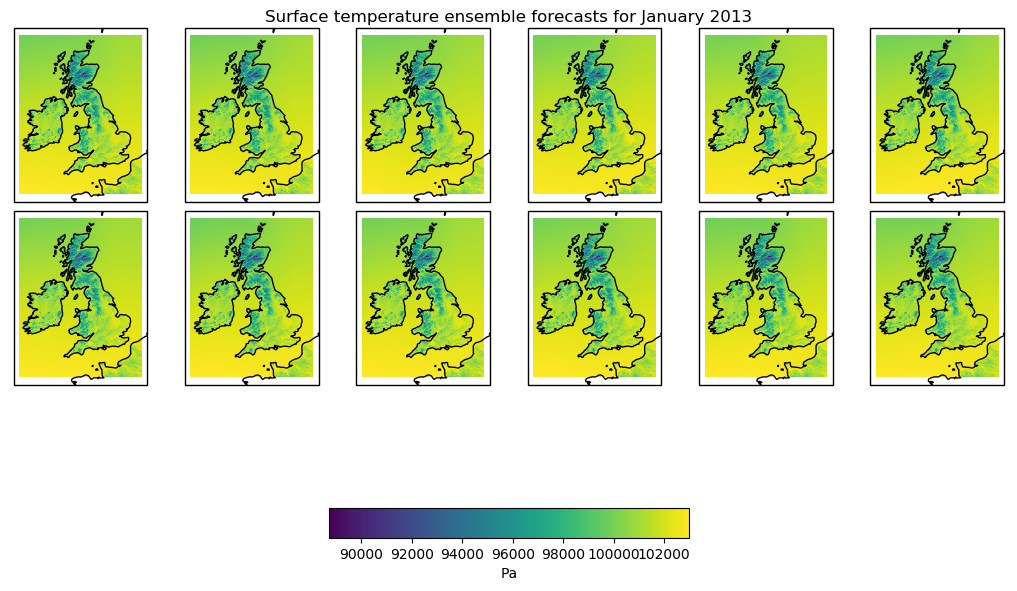

In [102]:
# Create a wider than normal figure to support our many plots
plt.figure(figsize=(12, 6), dpi=100)

# Also manually adjust the spacings which are used when creating subplots
plt.gcf().subplots_adjust(hspace=0.05, wspace=0.05, top=0.95, bottom=0.05, left=0.075, right=0.925)

# iterate over all possible latitude longitude slices
for cube in first_timestep.slices(['grid_latitude', 'grid_longitude']):

    # get the ensemble member number from the ensemble coordinate
    ens_member = cube.coord('realization').points[0]

    # plot the data in a 4x3 grid, with each plot's position in the grid being determined by ensemble member number
    plt.subplot(3, 6, ens_member+1)

    cf = iplt.pcolormesh(cube)

    # add coastlines
    plt.gca().coastlines('50m')

# make an axes to put the shared colorbar in
colorbar_axes = plt.gcf().add_axes([0.35, 0.1, 0.3, 0.05])
colorbar = plt.colorbar(cf, colorbar_axes, orientation='horizontal')
colorbar.set_label('%s' % first_timestep.units)

# limit the colorbar to 8 tick marks
import matplotlib.ticker
colorbar.locator = matplotlib.ticker.MaxNLocator(8)
colorbar.update_ticks()

# get the time for the entire plot
time_coord = first_timestep.coord('time')
time = time_coord.units.num2date(time_coord.points[0])

# set a global title for the postage stamps with the date formated by "monthname year"
plt.suptitle('Surface temperature ensemble forecasts for %s' % time.strftime('%B %Y'))

iplt.show()

## Calculating the ensemble mean

We may also wish to calculate the mean of the ensemble. We can do this by collapsing our cube along the `realization` dimension using the `MEAN` analysis operator.

In [91]:
ensemble_mean = first_timestep.collapsed('realization', iris.analysis.MEAN)
ensemble_mean

/opt/conda/lib/python3.6/site-packages/iris/coords.py:1210: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


<iris 'Cube' of surface_air_pressure / (Pa) (grid_latitude: 548; grid_longitude: 421)>

Now that we have calculated the mean we can plot it. This is an excellent example of the laziness in iris, the mean isn't actually calculated at this point, we have just created a cube which represents the mean of the data. When we ask matplotlib to draw the data it will then go away and run the calculation.

/opt/conda/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/conda/lib/python3.6/site-packages/iris/coords.py:1000: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


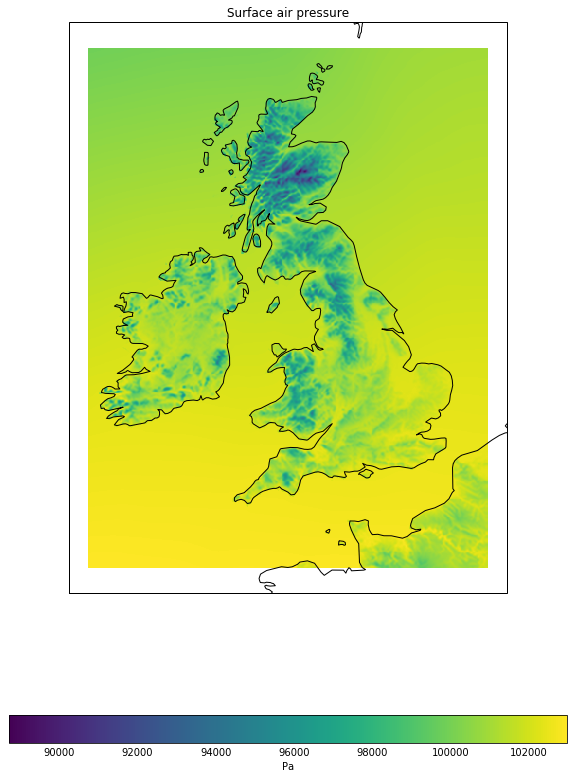

In [93]:
fig = plt.figure(figsize=(10, 15))

qplt.pcolormesh(ensemble_mean)

# Add coastlines to the map created by contourf.
plt.gca().coastlines('50m')

plt.show()